In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

data = pd.read_csv('oil_palm_production.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
# data.set_index('Date', inplace=True)

# Check for missing values
print(data.isnull().sum())

## Fill missing 'Rainfall' and 'Rainday' with the mean of the same month across years
data['Rainfall'] = data['Rainfall'].fillna(data.groupby(data['Date'].dt.month)['Rainfall'].transform('mean'))
data['Rainday'] = data['Rainday'].fillna(data.groupby(data['Date'].dt.month)['Rainday'].transform('mean'))

# Create lag features for Fertilizer, Rainfall, and Rainday up to 24 months
for i in range(1, 25):
    data[f'Fertilizer_lag_{i}'] = data['Fertilizer'].shift(i)
    data[f'Rainfall_lag_{i}'] = data['Rainfall'].shift(i)
    data[f'Rainday_lag_{i}'] = data['Rainday'].shift(i)

# Extract month
data['Month'] = data['Date'].dt.month

# Define a function to categorize age
def age_group(age):
    if age <= 3:
        return 'No Production'
    elif 4 <= age <= 8:
        return 'Low Increasing'
    elif 9 <= age <= 15:
        return 'Optimal'
    elif 16 <= age <= 20:
        return 'Plateauing'
    else:
        return 'Declining'

# Apply the function to create 'Age_Group'
data['Age_Group'] = data['Age'].apply(age_group)

# Convert 'Age_Group' into dummy variables
data = pd.get_dummies(data, columns=['Age_Group'], drop_first=True)

# Drop rows with NaN values resulting from lag features
data = data.dropna().reset_index(drop=True)

data.head(5)


Date          0
Production    0
Age           0
Area          0
Palm Stand    0
Fertilizer    0
Rainfall      2
Rainday       3
dtype: int64


,Date,Production,Age,Area,Palm Stand,Fertilizer,Rainfall,Rainday,Fertilizer_lag_1,Rainfall_lag_1,...,Rainday_lag_22,Fertilizer_lag_23,Rainfall_lag_23,Rainday_lag_23,Fertilizer_lag_24,Rainfall_lag_24,Rainday_lag_24,Month,Age_Group_Optimal,Age_Group_Plateauing
0,2015-01-01,14.08,7,9.01,1316,0.00,242.0,9.0,0.00,328.0,...,15.0,1.75,215.0,19.0,0.00,202.0,9.0,1,False,False
1,2015-02-01,16.34,7,9.01,1316,2.25,64.0,5.0,0.00,242.0,...,10.0,2.00,383.0,15.0,1.75,215.0,19.0,2,False,False
2,2015-03-01,19.63,7,9.01,1316,0.00,153.0,13.0,2.25,64.0,...,12.0,0.00,97.0,10.0,2.00,383.0,15.0,3,False,False
3,2015-04-01,22.51,7,9.01,1316,0.00,260.0,14.0,0.00,153.0,...,5.0,0.00,75.0,12.0,0.00,97.0,10.0,4,False,False
4,2015-05-01,19.36,7,9.01,1316,2.40,251.0,11.0,0.00,260.0,...,7.0,1.00,28.0,5.0,0.00,75.0,12.0,5,False,False


C:\Users\Asyraf Workstation\AppData\Local\Temp\ipykernel_20056\1175229962.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_production = data['Production'].resample('M').mean()


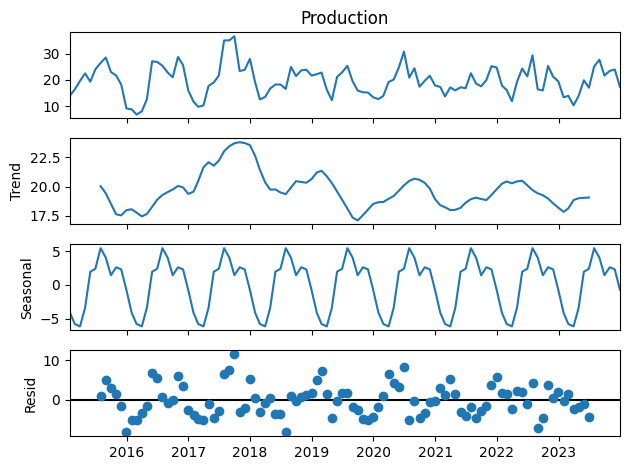

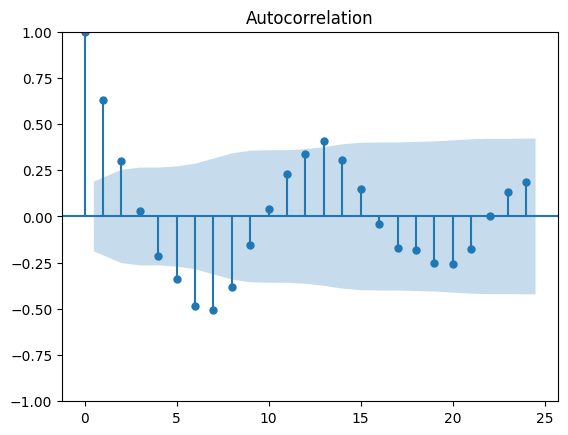

In [ ]:
# Testing for Yearly Seasonality in Production Data

data.set_index('Date', inplace=True)

# Resample data monthly (if not already)
monthly_production = data['Production'].resample('M').mean()

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(monthly_production, model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

# Plot ACF
plot_acf(monthly_production.dropna(), lags=24)
plt.show()


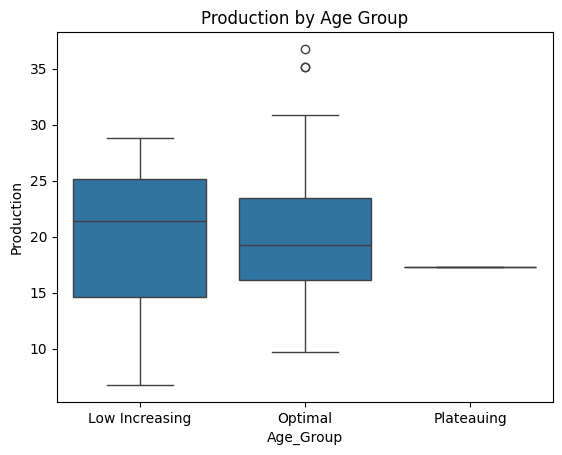

ANOVA F-statistic: 0.10, p-value: 0.9026


In [4]:
import scipy.stats as stats
import seaborn as sns

# Ensure 'Age_Group' is correctly categorized
data['Age_Group'] = data['Age'].apply(age_group)

# Visualize production by age group
sns.boxplot(x='Age_Group', y='Production', data=data)
plt.title('Production by Age Group')
plt.show()

# Extract production values for each age group
groups = [group['Production'].values for name, group in data.groupby('Age_Group')]

# Perform ANOVA
F_statistic, p_value = stats.f_oneway(*groups)

print(f'ANOVA F-statistic: {F_statistic:.2f}, p-value: {p_value:.4f}')


In [5]:
from scipy.stats import pearsonr

# Calculate Pearson correlation
corr_coeff, p_value = pearsonr(data['Palm Stand'], data['Production'])

print(f'Pearson correlation coefficient: {corr_coeff:.2f}, p-value: {p_value:.4f}')


Pearson correlation coefficient: 0.02, p-value: 0.8018


In [6]:
# Create binary variable for extreme rainfall
data['Extreme_Rainfall'] = 0

# Low rainfall condition
low_rainfall = data['Rainfall'] < 100
data['Low_Rainfall_3M'] = low_rainfall.rolling(window=3).sum() == 3

# High rainfall condition
high_rainfall = data['Rainfall'] > 300
data['High_Rainfall_3M'] = high_rainfall.rolling(window=3).sum() == 3

# Update 'Extreme_Rainfall' column
data.loc[data['Low_Rainfall_3M'] | data['High_Rainfall_3M'], 'Extreme_Rainfall'] = 1

# Regression Analysis
X = data[['Extreme_Rainfall']]
X = sm.add_constant(X)
y = data['Production']

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Production   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.4194
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.519
Time:                        03:15:16   Log-Likelihood:                -342.94
No. Observations:                 108   AIC:                             689.9
Df Residuals:                     106   BIC:                             695.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               19.8521      0.573  